# Importing necessary libraries

In [40]:
%pip install transformers[sentencepiece]

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm.notebook import tqdm

In [42]:
import warnings
warnings.filterwarnings("ignore")

# Creating a Sample Dataset for the task

In [43]:
data = {
    'text': [
        "This product is amazing! I love it.",
        "The worst shopping experience ever. I'm very disappointed.",
        "Not bad, but could be better.",
        "Fast and efficient service. Highly recommended.",
        "Terrible quality and horrible customer service.",
        "Average product, nothing exceptional.",
        "Outstanding quality and exceptional customer support.",
        "I'm satisfied with my purchase. It met my expectations.",
        "I regret buying this. Such a waste of money.",
        "Good value for the price.",
        "I couldn't be happier with my purchase. It's perfect!",
        "Poor customer service and slow shipping.",
        "It's an okay product. Not great, not terrible.",
        "Prompt delivery and great product quality.",
        "The item was defective and the return process was a nightmare."
    ],
    'sentiment': ['positive', 'negative', 'neutral', 'positive', 'negative', 'neutral', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative']
}

# Exploratory Data Analysis

## Converting data into a proper dataframe

In [44]:
df = pd.read_csv('/content/reviews.csv',error_bad_lines=False, engine="python")
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [45]:
df = df[['Title', 'Review Text', 'Rating']]
df.head()

,Title,Review Text,Rating
0,NaN,Absolutely wonderful - silky and sexy and comf...,4
1,NaN,Love this dress! it's sooo pretty. i happene...,5
2,Some major design flaws,I had such high hopes for this dress and reall...,3
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5
4,Flattering shirt,This shirt is very flattering to all due to th...,5


In [46]:
df.Title.fillna("", inplace=True)
df['Review Text'].fillna("", inplace=True)
df.head()

,Title,Review Text,Rating
0,,Absolutely wonderful - silky and sexy and comf...,4
1,,Love this dress! it's sooo pretty. i happene...,5
2,Some major design flaws,I had such high hopes for this dress and reall...,3
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5
4,Flattering shirt,This shirt is very flattering to all due to th...,5


In [47]:
df['text'] = df['Title'] + ' -- ' + df['Review Text']
df.head()

,Title,Review Text,Rating,text
0,,Absolutely wonderful - silky and sexy and comf...,4,-- Absolutely wonderful - silky and sexy and ...
1,,Love this dress! it's sooo pretty. i happene...,5,-- Love this dress! it's sooo pretty. i hap...
2,Some major design flaws,I had such high hopes for this dress and reall...,3,Some major design flaws -- I had such high hop...
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,"My favorite buy! -- I love, love, love this ju..."
4,Flattering shirt,This shirt is very flattering to all due to th...,5,Flattering shirt -- This shirt is very flatter...


In [48]:
sentiment_mapping = {
    1: 'very negative',
    2: 'negative',
    3: 'neutral',
    4: 'positive',
    5: 'very positive'
}
df['sentiment'] = df['Rating'].map(sentiment_mapping)

df.head()

,Title,Review Text,Rating,text,sentiment
0,,Absolutely wonderful - silky and sexy and comf...,4,-- Absolutely wonderful - silky and sexy and ...,positive
1,,Love this dress! it's sooo pretty. i happene...,5,-- Love this dress! it's sooo pretty. i hap...,very positive
2,Some major design flaws,I had such high hopes for this dress and reall...,3,Some major design flaws -- I had such high hop...,neutral
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,"My favorite buy! -- I love, love, love this ju...",very positive
4,Flattering shirt,This shirt is very flattering to all due to th...,5,Flattering shirt -- This shirt is very flatter...,very positive


In [49]:
df.isna().sum()

Title          0
Review Text    0
Rating         0
text           0
sentiment      0
dtype: int64

In [50]:
df = df[['text', 'sentiment']]
df.head()

,text,sentiment
0,-- Absolutely wonderful - silky and sexy and ...,positive
1,-- Love this dress! it's sooo pretty. i hap...,very positive
2,Some major design flaws -- I had such high hop...,neutral
3,"My favorite buy! -- I love, love, love this ju...",very positive
4,Flattering shirt -- This shirt is very flatter...,very positive


## Getting full information of the dataframe

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       23486 non-null  object
 1   sentiment  23486 non-null  object
dtypes: object(2)
memory usage: 367.1+ KB


## Plotting the distribution of sentiments in our dataset

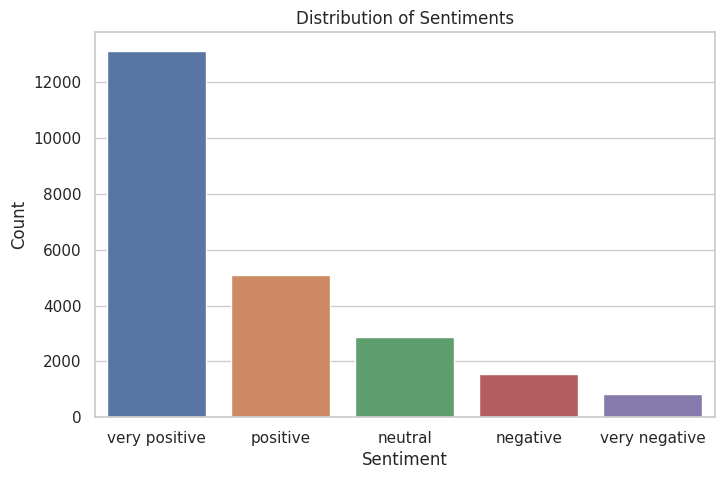

In [52]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment', order=['very positive', 'positive', 'neutral', 'negative', 'very negative'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Creating word clouds for different types of reviews

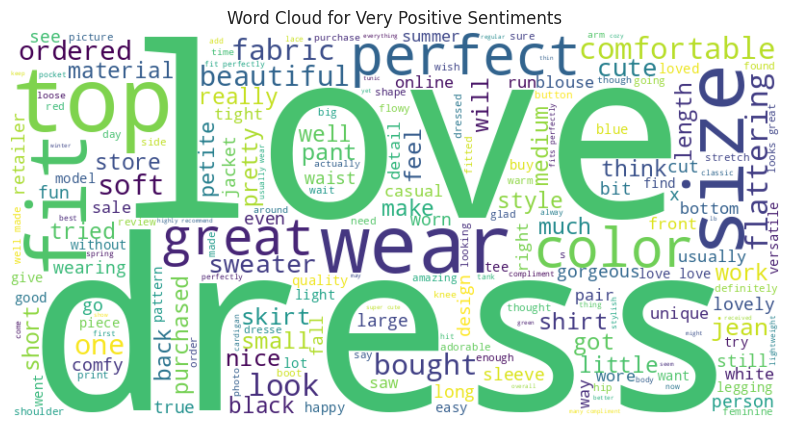

In [53]:
very_positive_reviews = " ".join(df[df['sentiment'] == 'very positive']['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(very_positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Very Positive Sentiments')
plt.show()

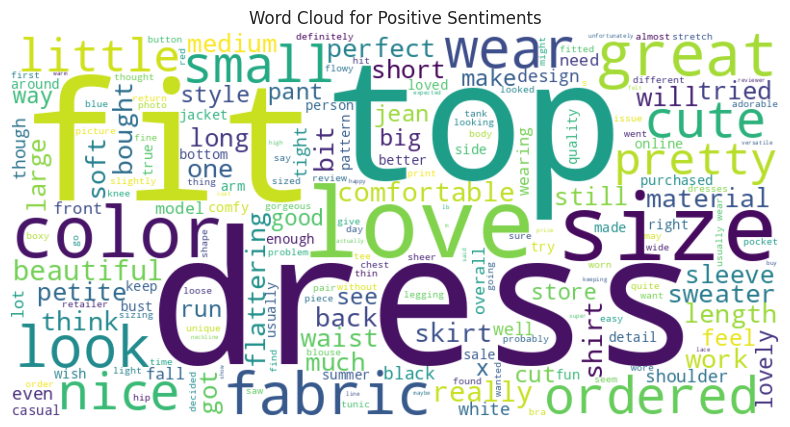

In [54]:
positive_reviews = " ".join(df[df['sentiment'] == 'positive']['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Positive Sentiments')
plt.show()

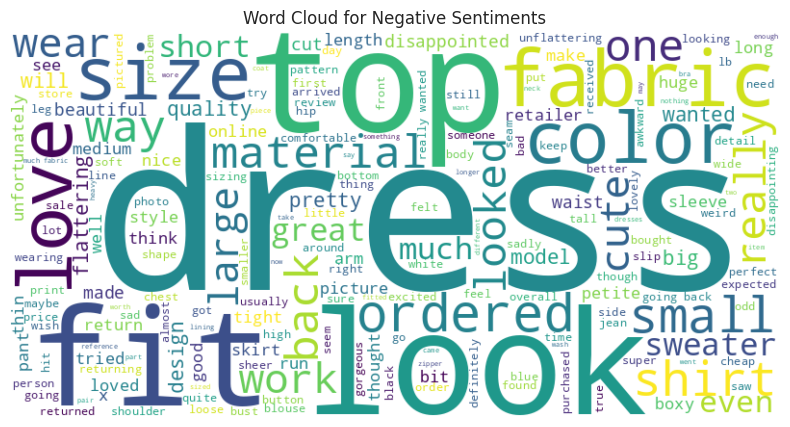

In [55]:
negative_reviews = " ".join(df[df['sentiment'] == 'negative']['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Negative Sentiments')
plt.show()

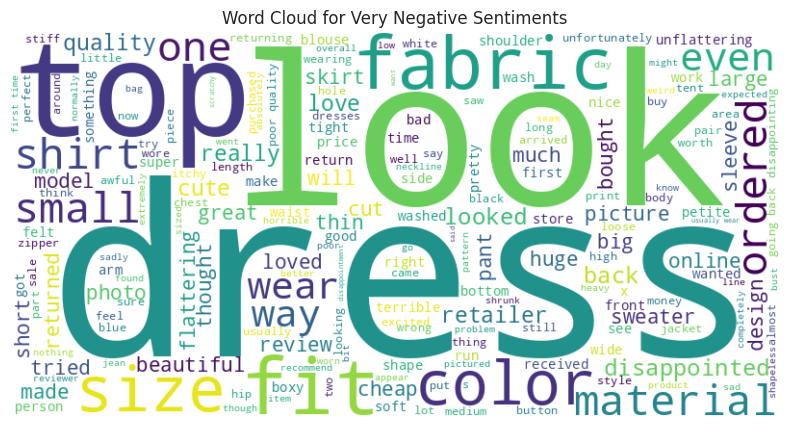

In [56]:
very_negative_reviews = " ".join(df[df['sentiment'] == 'very negative']['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(very_negative_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Very Negative Sentiments')
plt.show()

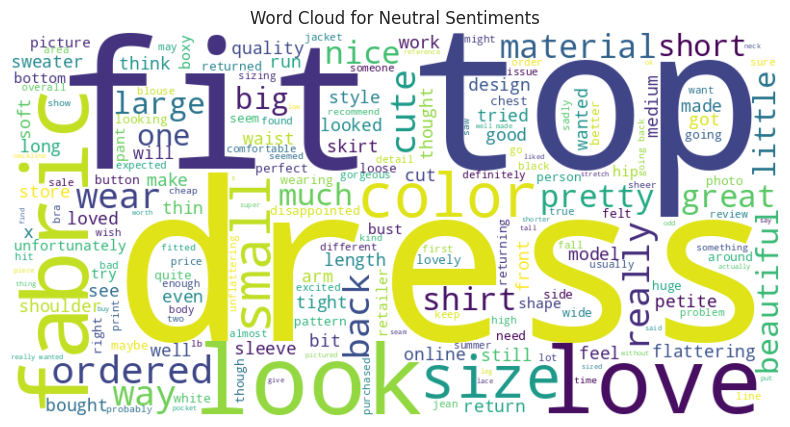

In [57]:
neutral_reviews = " ".join(df[df['sentiment'] == 'neutral']['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Neutral Sentiments')
plt.show()

# Splitting the dataset

## Firstly only taking a certain subset of the dataset with equal number of observations of all classes

In [58]:
grouped = df.groupby('sentiment')

# Initialize an empty list to store the samples
samples = []

# Sample one instance from each group
for group_name, group_data in grouped:
    sample = group_data.sample(n=50, random_state=42)  # Sample 50 instance per class
    samples.append(sample)

subset_df = pd.concat(samples)
subset_df.reset_index(drop=True, inplace=True)
subset_df.head()

,text,sentiment
0,Snug and unflattering -- Would be flattering o...,negative
1,The sleeves..... -- I was aware of the split s...,negative
2,Huge - swallowed me whole -- I had high hopes ...,negative
3,So baggy -- I grabbed this dress to try on in ...,negative
4,Not for tall ladies -- This sweater is a cute ...,negative


In [59]:
X = subset_df['text']
y = subset_df['sentiment']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Mapping sentiment into numeric labels

In [61]:
label_mapping = {'very positive':4, 'positive': 3, 'neutral': 2, 'negative': 1, 'very negative':0}
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

# Model Training

## Initializing Model

In [62]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Getting encodings for the reviews

In [63]:
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, return_tensors='pt', max_length=64)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, return_tensors='pt', max_length=64)

## Creating dataset and Data loaders

In [64]:
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train.tolist()))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test.tolist()))
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)

## Initializing optimizer and checking for cuda compatibility

In [65]:
optimizer = AdamW(model.parameters(), lr=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model is ready to train

In [66]:
model.to(device)
model.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Initializing list to store training losses through epochs

In [67]:
train_losses = []

## Training

In [68]:
for epoch in range(3):
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

Epoch 1:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/67 [00:00<?, ?it/s]

## Plotting training loss values

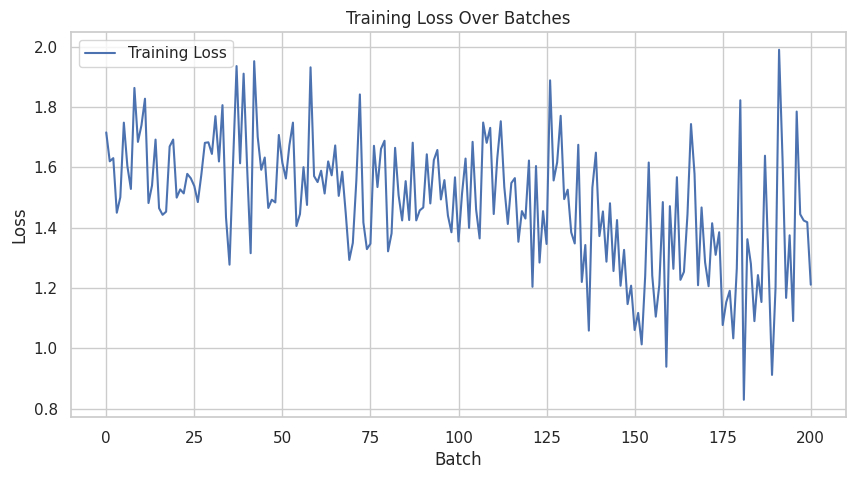

In [69]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Over Batches")
plt.show()

# Model Evaluation

In [70]:
model.eval()
all_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

## Displaying Model Results

In [71]:
accuracy = accuracy_score(y_test, all_preds)
report = classification_report(y_test, all_preds)

print(f"Accuracy: {accuracy}\n\n")
print("Classification Report:")
print(report)

Accuracy: 0.46


Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.73      0.53        11
           1       0.45      0.38      0.42        13
           2       0.17      0.14      0.15         7
           3       1.00      0.10      0.18        10
           4       0.62      0.89      0.73         9

    accuracy                           0.46        50
   macro avg       0.53      0.45      0.40        50
weighted avg       0.54      0.46      0.41        50



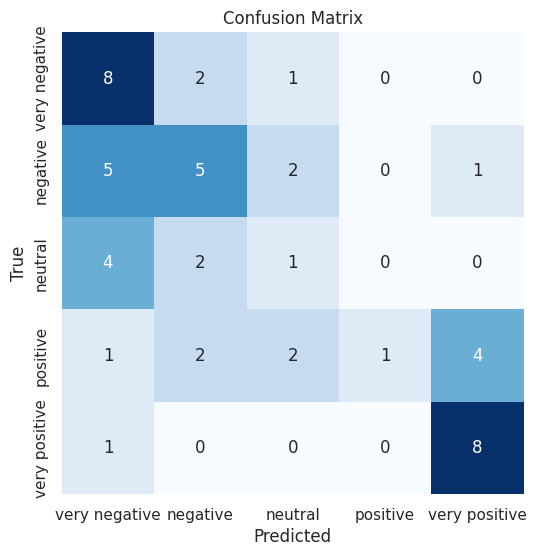

In [75]:
confusion = confusion_matrix(y_test, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=['very negative', 'negative', 'neutral', 'positive', 'very positive'],
            yticklabels=['very negative', 'negative', 'neutral', 'positive', 'very positive'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()